### 베이스라인에 있는 코드 참고
- QLoRA + LDCC-SOLAR-10.7B
- 데이터 전처리: 질문은 하나하나 보면서 바꿈(답변이랑 관련 없는 질문 대체), 답변은 다 보기엔 너무 길어서 살짝 대충(홈페이지 주소, 영어 문장, 특수 기호 삭제)
- 모델파라미터, max_length 변경

## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install peft #Parameter-Efficient Fine-Tuning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.2 MB/s eta 0:00:00


In [ ]:
pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 14.2 MB/s eta 0:00:00


In [ ]:
pip install accelerate

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import os
from transformers import PreTrainedTokenizerFast, AdamW, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from tqdm import tqdm

#os.environ["TOKENIZERS_PARALLELISM"] = "true"
#torch.backends.cuda.matmul.allow_tf32=True
#torch.set_float32_matmul_precision('medium')
#torch.backends.cudnn.benchmark = True

## Data Preprocessing

In [ ]:
import os
original_directory = os.getcwd()
try:
  # 필요한 디렉토리로 변경
  os.chdir("/content/drive/MyDrive/데이콘/한솔데코/Augmentation_file")
  #BERT 증강
  from BERT_augmentation import BERT_Augmentation
  #from adverb_augmentation import AdverbAugmentation
  from koreda import random_insertion
  from aeda import aeda
  BERT_aug = BERT_Augmentation()
  random_masking_insertion = BERT_aug.random_masking_insertion
finally:
    # 원래 디렉토리로 돌아갑니다.
    os.chdir(original_directory)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/149M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/데이콘/한솔데코/train_전처리완료.csv', encoding='cp949')

In [ ]:
data

,id,질문_1,질문_2,category,답변_1,답변_2,답변_3,답변_4,답변_5
0,TRAIN_000,면진장치가 뭐야?,면전장치란 무엇인가요?,건축구조,면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 ...,"면진장치란 건물의 지반에서 발생하는 진동 에너지를 흡수하여 건물을 보호하고, 진동을...",면진장치란 지반으로부터 발생하는 진동 에너지를 흡수하여 건물에 전달되는 진동을 줄여...,면진장치는 건물의 지반으로부터 오는 진동 에너지를 흡수하여 건물에 전달되는 진동을 ...,면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동...
1,TRAIN_001,내진설계의 종류 좀 알려줘,내진설계에는 어떤 종류가 있는지 자세히 알려주실 수 있나요?,건축구조,"내진 설계의 종류로 내진구조, 제진구조, 면진구조가 있습니다.","내진설계에는 내진구조, 제진구조, 면진구조가 있습니다. 내진구조는 건물 구조물이 지...","내진설계에는 주로 내진구조, 제진구조, 면진구조의 세 가지 종류가 있습니다. 이들은...","내진설계에는 주로 내진구조, 제진구조, 면진구조가 사용됩니다. 내진구조는 건물 구조...","내진 설계에는 다양한 종류가 있지만, 대표적으로 내진구조, 제진구조, 면진구조가 있..."
2,TRAIN_002,철골구조의 장점이 뭐야?,철골구조의 장점을 알려줘?,건축구조,철골구조는 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건축이 가...,철골구조의 장점은 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건...,철골구조의 장점은 건물의 외벽에 하중이 적게 걸리기 때문에 고층 건물의 건축이 용이...,"철골구조의 장점은 건물의 외벽이 하중이 걸리지 않아 공간 활용이 용이하고, 고층 건...",철골구조의 장점은 건물의 외벽에 하중이 크게 걸리지 않아 고층 건물을 건축할 수 있...
3,TRAIN_003,철골철근 콘크리트 구조가 뭐야?,철골철근 콘크리트 구조에 대해 설명해줘.,건축구조,"철근철골콘크리트는 철골과 철근, 그리고 콘크리트를 함께 사용하는 건축 구조입니다. ...","철골철근콘크리트 구조는 건축물을 지탱하는 주요 구조물인 철골과 철근, 그리고 콘크리...",철골철근 콘크리트 구조는 건축물을 지탱하기 위한 구조물에서 일반적으로 사용되는 방식...,"철골철근콘크리트 구조는 철골과 철근, 그리고 콘크리트를 함께 사용하여 만들어지는 건...","철골철근 콘크리트 구조는 강철 골조와 강철 철근, 그리고 콘크리트를 함께 사용하여 ..."
4,TRAIN_003,철골철근 콘크리트 구조의 장단점을 알려줘.,철골철근 콘크리트 구조의 장점과 단점에는 무엇이 있을까요?,건축구조,"철골은 강하고 가벼운 소재로, 높은 내구성과 강도를 가지고 있어 대규모 공간이나 강...","이 구조는 철골의 강도와 내구성, 철근의 인장력, 그리고 콘크리트의 압축력을 조합하...",이 구조 방식은 철골의 내구성과 강도를 높이면서도 화재에 대한 안전성을 높일 수 있...,"이 구조는 철골의 강도와 내구성을 바탕으로 건물을 지지하고, 철근은 인장력을, 콘크...","이 구조는 강철 골조가 건물을 지탱하고 그 주변에 강철 철근과 콘크리트로 감싸거나,..."
...,...,...,...,...,...,...,...,...,...
641,TRAIN_639,벽장 부위 결로의 원인이 뭐야?,벽장 부위 결로가 발생하는 주된 원인은 무엇일까요?,타 마감하자,벽장 부위 결로의 원인은 난방이 이웃한 방과동일한 조건이 되나 그 방에 비해 저온인...,"벽장 부위 결로의 원인은 주로 난방이 자리잡은 방이 내부 온도가 낮은 반면, 외부 ...",벽장 부위 결로가 발생하는 원인은 난방이 잘 이루어지지 않아 해당 공간이 저온인 반...,"벽장 부위 결로가 발생하는 원인은 난방이 인접한 방과 같은 조건을 갖추고 있지만, ...",벽장 부위 결로의 주된 원인은 충분한 환기가 이루어지지 않는 환경과 과도한 습기가 ...
642,TRAIN_640,"AD, PD에 면한 벽체 결로의 원인이 뭐야?",벽체 결로가 AD나 PD에 면한다면 그 원인이 무엇인가요?,타 마감하자,"AD, PD에 면한 벽체 결로의 원인은 외기에 접하는 면 좌, 우측 벽체에는 단열재...","AD, PD에 면한 벽체 결로의 원인은 외기에 접하는 면 좌, 우측 벽체에는 단열재...","AD, PD에 면한 벽체 결로의 주된 원인은 외기에 접하는 면 좌, 우측 벽체에 단...","AD, PD에 면한 벽체 결로의 원인으로는 외기에 접하는 면 좌, 우측 벽체는 일반...","AD, PD에 면한 벽체 결로의 원인으로는 외부 공기에 노출된 벽면이 실내보다 냉각..."
643,TRAIN_641,외벽 모서리 부위에 결로가 발생하는 원인이 뭐야?,외벽 모서리 부위에 결로가 발생하는 원인은 무엇일까요?,타 마감하자,외벽모서리 부위에 결로가 발생하는 원인은 높은 온도차 때문입니다. 외벽 모서리의 경...,외벽 모서리 부위에 결로가 발생하는 원인은 중요한 역할을 합니다. 외부에 비치는 세...,외벽 모서리 부위에 결로가 발생하는 원인으로는 높은 온도차가 대표적입니다. 외벽 모...,외벽 모서리 부위에 결로가 발생하는 원인은 실내와 외부의 온도차 때문입니다. 외벽 ...,외벽 모서리 부위에 결로가 발생하는 주요 원인은 높은 온도차입니다. 외벽 모서리는 ...
644,TRAIN_642,창호 결로의 대책은 뭐야?,창호 결로를 해결하기 위한 가장 효과적인 방법은 무엇인가요?,타 마감하자,창호결로의 대책은 제품을 선정할 때 KS에 규정된 프레임을 선정하고 유리의 열관류율...,창호 결로의 대책은 KS에 규정된 프레임을 선정하고 유리의 열관류율 및 결로 발생 ...,"창호 결로를 예방하기 위한 대책은 KS에 규정된 프레임을 선택하고, 열관류율이 적은...","창호 결로의 대책은 여러 가지가 있습니다. 먼저, 창호를 선택할 때 KS에 규정된 ...","창호 결로를 방지하기 위한 대책으로는 KS에 규정된 프레임을 사용하고, 열관류율 및..."


In [ ]:
random_masking_insertion(input_text[:513],0.15)

'도배지 꼬임에 대해 자세히 설명해줘 < / / / s > 도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 도배지 꼬임 하자가 발생하는 원인 - 책임소재 : 원인 - 해결방법에 대해 자세히 설명드리겠습니다. 1. 공간 내 높은 습도 원인 : 습기가 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 꼬임이 발생할 수 있습니다. 책임소재 : 건물의 소유자나 거주자가 습기 관리의 책임이 돼 있습니다. 해결의 방법 : 실내 제습기 가동, 환기를 통해 최대한 실내 적정 습도를 유지하고 전문가의 도움을 받아 보수작업해야 합니다. 2. 벽면의손상 ( 불균형 ) 의 원인 : 벽면에 손상이 남아 있을 경우 손상된 벽을 통해 습기가 계속 유입하는 등의 원인으로 인해 꼬임이 발생할 가능성이 있습니다. 책임소재 : 벽면에 손상을 방생시킨 주체가 스스로 책임을 집니다. 해결 방법 : 벽면을 제대로 잘 복원하고 평평하게 균형을 맞춘 후 재작업을 해야 합니다. 해당 작업은 개인이 하기 어려우니 전문가의 도움을 받는 것을 추천합니다. ( 3. 불안정한 온도 원인 : 온도의 큰 폭 변화는 도배지의 수분 팽창과'

In [ ]:
for _, row in tqdm(data[338:].iterrows()):
  for q_col in ['질문_1', '질문_2']:
    for a_col in ['답변_1', '답변_2', '답변_3', '답변_4', '답변_5']:
      input_text = row[q_col] + tokenizer.eos_token + row[a_col]
      input_ids = tokenizer.encode(input_text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
      formatted_data.append(input_ids)
      input_text2=random_masking_insertion(input_text[:513], 0.15)
      formatted_data.append(tokenizer.encode(input_text2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length))
print('Done.')


308it [19:59,  3.90s/it]

Done.


In [ ]:
# 텐서들을 결합
cat_data = torch.cat(formatted_data, dim=0)

## Model Fine-tuning

In [ ]:
model_id = "LDCC/LDCC-SOLAR-10.7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",#nf4 -> neuralFloat4
    bnb_4bit_compute_dtype=torch.float16#loat16은 최신 GPU에서 빠르게 처리될 수 있는 데이터 타입
)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"":0},
                                             )


model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


config = LoraConfig(
    r=32,
    lora_alpha=16,
    #target_modules=["query_key_value"],
    target_modules=[
    "q_proj",
    "up_proj",
    "o_proj",
    "k_proj",
    "down_proj",
    "gate_proj",
    "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

trainable params: 125829120 || all params: 5753933824 || trainable%: 2.1868364122499857


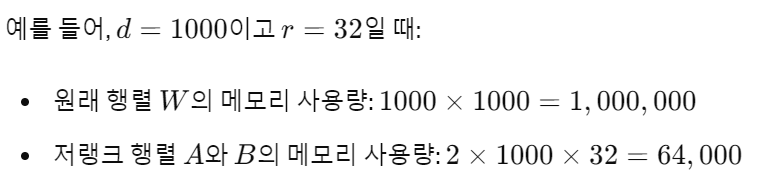

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=cat_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=10,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,1.733600
20,1.488600
30,1.294600
40,1.375900
50,1.258300
60,1.234200
70,1.238700
80,1.198200
90,1.283700
100,1.175900


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=9708, training_loss=0.36029087201675664, metrics={'train_runtime': 10695.2159, 'train_samples_per_second': 3.63, 'train_steps_per_second': 0.908, 'total_flos': 5.027648637321216e+17, 'train_loss': 0.36029087201675664, 'epoch': 3.0})

# Inference

In [ ]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer # SentenceTransformer Version 2.2.2

# Embedding Vector 추출에 활용할 모델(distiluse-base-multilingual-cased-v1) 불러오기
model_eval = SentenceTransformer('distiluse-base-multilingual-cased-v1')

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Wed Feb 28 04:50:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              51W / 400W |  40327MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from transformers import pipeline
checkpoint_path = "/content/outputs/checkpoint-9500"
# 질문은 출력 안하는 return_full_text=False
text_generation = pipeline("text-generation", model='/content/outputs/checkpoint-9500', return_full_text=False)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pip install llama_cpp_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 42.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for llama_cpp_python: filename=llama_cpp_python-0.2.56-cp310-cp310-manylinux_2_35_x86_64.whl size=2834972 sha256=0b6503c4381565d60413e5997a431ea7e82a84e29749f917ec2eb27a84e6378e
  Stored in directory: /root/.cache/pip/wheels/e5/09/9d/c413053f6258cb2546cc792418c595e276f9efd5db31a80377
Successfully built llama_cpp_python


In [ ]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b) if norm_a != 0 and norm_b != 0 else 0

generation_kwargs = {
        "max_tokens":200,
        "stop":["</s>"],
        "echo":False, # Echo the prompt in the output
        "top_k":1 # This is essentially greedy decoding, since the model will always return the highest-probability token. Set this value > 1 for sampling decoding
    }

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/데이콘/한솔데코/test.csv')

In [ ]:
import numpy as np

res_score2=[]
for test_question in test_data['질문']:
  input_ids = tokenizer.encode(test_question+tokenizer.eos_token, return_tensors='pt')
  outputs = model.generate(input_ids, max_length=200)
  for generated_sequence in outputs:
    full_text = tokenizer.decode(generated_sequence, skip_special_tokens=False)
    # 질문과 답변의 사이를 나타내는 eos_token (</s>)를 찾아, 이후부터 출력
    answer_start = full_text.find(tokenizer.eos_token) + len(tokenizer.eos_token)
    answer_only = full_text[answer_start:].strip()
    answer_only = answer_only.replace('\n', ' ')
    res_score2.append(answer_only)


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use

max_length 200, 150, 128 제출

In [ ]:
res_score3=[]
for i in res_score2:
  res_score3.append((i.replace('< / s >',''))[:128])

In [ ]:
res_score3

['방청 페인트의  종류로는  광 명단페인 트, 방청산화철페인 트, 알미늄페인 트, 역청질페인 트, 워시프라이머 , 크롬 산아연페인 트, 그리고  규산염페인 트 등이  있습니다 . 이러한 다양한 종류 의 방청 페인트는  각자의  특징',
 '도배지에  녹 은 자국이  발생하는  원인 은 여러 가지 가 있을  수 있지 만, 주로  고온과 습도가  높 은 환경에서  도배지 표면이  녹 은 후 다시  건조되면서  발생 할 수 있습니다 . 이러한 상황에서는  냉 열기를  가',
 '큐 블럭 의 단점은  주로  가격 이 상대적으로  높 고 축 열 성능이 떨어진다 는 점입니다 . 또한  압 출법 단열판은  비드 법 단열재에 비해 가격 이 높 고 충 격에 약해서  파손율이  높 은 편이기도  합니다 . 이러한 단',
 '철골구조 를 사용하는  고층  건물에 서 단열 효과 를 높이기  위한  방법 은 다양합니다 . 먼 저, 철골  구조 는 강철   skeleton 을 이용하여  건물을  지지하기  때문에  내부 공간 은 외벽 과 내벽  사이 에 단',
 '만약 건조 기간  동안  온도와  습도에  대해 주의해야  하는  이유가  무엇인가요 ?  도배 후 완전 건조되기  전까지  최대 일주일 이 걸릴  수 있습니다 . 건조 기간  동안  온도와  습도에  유의해야  하며 , 일주일 ',
 '철 근철골콘 크리트  구조 는 철 근과 철골 을 사용하여  강도를  높 인 콘 크리트  구조 로, 내구성 , 내화 및 내진 성능이 우수합니다 . 그러나  고층  건물에서는  아래층의  보나 기둥이  상당한  무게를 지탱해야  하므',
 '개별 공간 은 개인 의 공간 과 더 많은  프라이 버시를  제공하는  반면, 오픈  플랜 은 공간 을 확장시키고  연결감을  높 여 활동적인  라이프스타일 을 즐기기 에 더 적합할 수 있습니다 . 합지벽지의  단점은  상대적으로 ',
 ' 도배지 들뜸  현상은  주로  습도, 온도 차이, 또는  벽면의  손상으로  인해 발생합니다 . 특히  습도가  너무 

In [ ]:
pred_embeddings = model_eval.encode(res_score3)
new_col = ['vec_' + str(i) for i in range(512)]
rr=np.array(pred_embeddings)
df_sub = pd.DataFrame(columns=new_col, data=rr)
df_sub.insert(0, column='id', value=test_data['id'])
df_sub.to_csv('final4.csv', index=False)